In [78]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy

In [115]:
def get_Ag(fn):
    df = nc.Dataset(fn)

    re_name = "re_fcoeffs"
    im_name = "im_fcoeffs"

    real = df.variables[re_name][:]
    imag = df.variables[im_name][:]

    wlat = df.variables['wavelength_lat'][:]
    wlon = df.variables['wavelength_lon'][:]

    df.close()
    
    ncells = real.shape[0]

    AE = 6371.0008 * 1E3 # Earth's radius in [m]

    wla = wlat * AE
    wlo = wlon * AE

    hhg = real + 1.0j * imag

    # print(hhg)

    N = 0.02 # s^{-1}
    U = 10.0 # m s^{-1}
    V = 10.0 # m s^{-1}

    kk = np.arange(0,12)
    ll = np.arange(-6,6)

    # print(kk, ll)
    kkg, llg = np.meshgrid(kk,ll)
    # print(kkg.shape, llg.shape)

    kkg = np.expand_dims(kkg,0)
    llg = np.expand_dims(llg,0)
    wla = np.expand_dims(wla,1)
    wlo = np.expand_dims(wlo,1)
    wla = np.expand_dims(wla,1)
    wlo = np.expand_dims(wlo,1)
    # print(kkg.shape, llg.shape)
    # print(wla.shape, wlo.shape)

    # kkg = np.dot(1.0 / wlo, kkg)
    kkg = np.repeat(kkg, ncells, axis=0) / wlo
    llg = np.repeat(llg, ncells, axis=0) / wla

    # print(kkg.shape, llg.shape)
    # print(kkg**2 + llg**2)

    omg_grid_sq = (- kkg * U - llg * V)**2
    # print(omg_grid_sq)

    Ag = 0.5 * ( hhg * np.conj(hhg) * N**2 / np.sqrt(omg_grid_sq) ) #* 1e-12
    Ag = np.real(Ag)
    Ag = Ag.sum(axis=(1,2))
    # Ag[np.where(Ag==np.nan)] = 0.0
    Ag = Ag.filled(np.nan)
    # Ag[np.ma.masked_invalid(Ag)] = np.nan
    # print(Ag.shape)

    # mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))
    # print(mmg)

    # print(Ag[100:200])
    return Ag

In [116]:
def remove_high_lats(arr, lats, lat_trunc=80):
    arr = arr[np.where(lats < lat_trunc)]
    return arr


In [163]:
sfx = '0010'

fn_norot = '../data/output_axial_norot_%s.nc' %sfx
Ag_norot = get_Ag(fn_norot)

fn_rot = '../data/output_axial_search_%s.nc' %sfx
Ag_rot = get_Ag(fn_rot)

df = nc.Dataset('../data/icon_grid_0010_R02B04_G_linked.nc')

clat = df.variables['clat'][:]
clon = df.variables['clon'][:]
# clat_vertices = df.variables['clat_vertices'][:]
# clon_vertices = df.variables['clon_vertices'][:]
# links = df.variables['links'][:]

lats = np.rad2deg(clat)
lons = np.rad2deg(clon)

df.close()

Ag_norot = remove_high_lats(Ag_norot, lats)
Ag_rot = remove_high_lats(Ag_rot, lats)
lons = remove_high_lats(lons, lats)
lats = remove_high_lats(lats, lats)

/tmp/ipykernel_245998/534507914.py:56: RuntimeWarning: invalid value encountered in sqrt
  Ag = 0.5 * ( hhg * np.conj(hhg) * N**2 / np.sqrt(omg_grid_sq) ) #* 1e-12


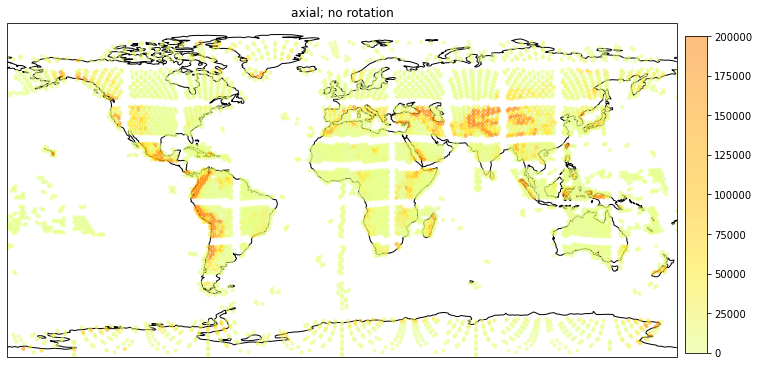

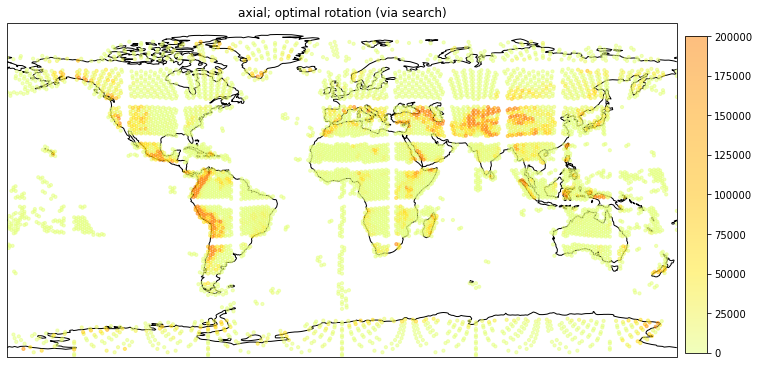

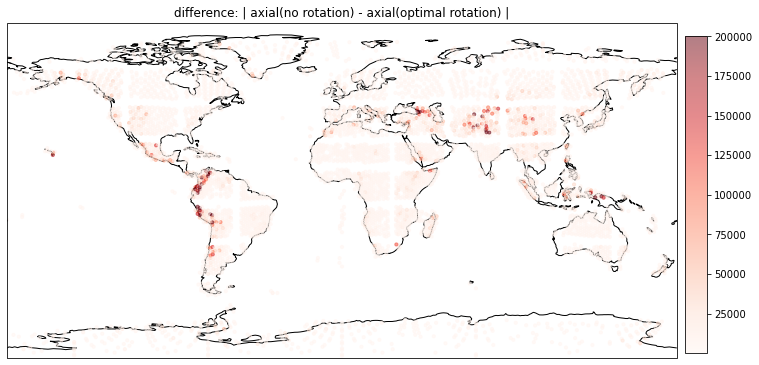

In [219]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(16, 12))
# ax1 = fig.add_subplot(211)
# im1 = ax1.scatter(x=lons, y=lats,
#             s=0.5,
#             c=Ag_norot,
#             alpha=0.5,
#             transform=ccrs.PlateCarree(),
#             norm=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical')

# ax2 = fig.add_subplot(212)
# im2 = ax2.scatter(x=lons, y=lats,
#             s=0.5,
#             c=Ag_norot,
#             alpha=0.5,
#             transform=ccrs.PlateCarree(),
#             norm=None)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical')


fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.tricontour(lons,lats,Ag,80, transform=ccrs.PlateCarree())
ax.coastlines()
im = ax.scatter(x=lons, y=lats,
            # color="dodgerblue",
            s=10.0,
            c=Ag_norot,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            norm=None,
            cmap='Wistia',
            vmax=200000)
ax.set_global()
ax.set_title("axial; no rotation")

cax = fig.add_axes([0.91, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)
plt.show()



fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.tricontour(lons,lats,Ag,80, transform=ccrs.PlateCarree())
ax.coastlines()
im = ax.scatter(x=lons, y=lats,
            # color="dodgerblue",
            s=10.0,
            c=Ag_rot,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            norm=None,
            cmap='Wistia',
            vmax=200000)
ax.set_global()

ax.set_title("axial; optimal rotation (via search)")

cax = fig.add_axes([0.91, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)
plt.show()



diff = np.abs(Ag_norot - Ag_rot)# / Ag_norot
diff[np.where(diff < 1e1)] = np.nan

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.tricontour(lons,lats,Ag,80, transform=ccrs.PlateCarree())
ax.coastlines()
im = ax.scatter(x=lons, y=lats,
            # color="dodgerblue",
            s=10.0,
            c=diff,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            norm=None,
            cmap='Reds',
            vmax=200000)
ax.set_global()

ax.set_title("difference: | axial(no rotation) - axial(optimal rotation) |")

cax = fig.add_axes([0.91, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)
plt.show()

In [165]:
print(diff[diff > 0.0])

[1.41741032e+02 2.41680550e+02 3.91191511e+02 ... 4.69356634e+02
 3.08572856e+02 3.81761343e-01]


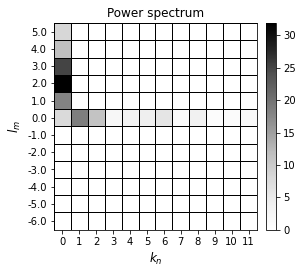

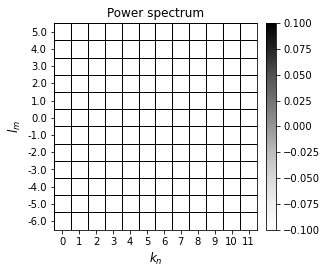

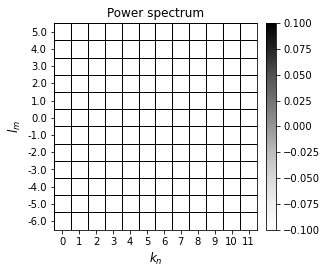

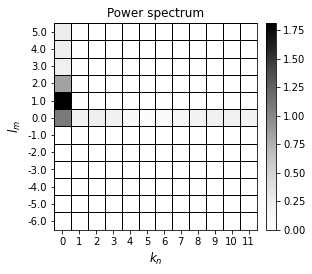

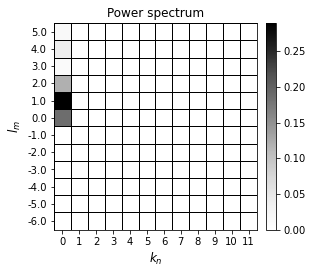

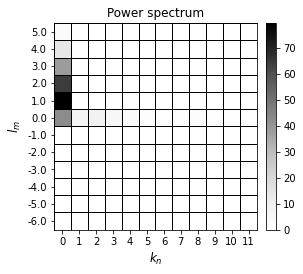

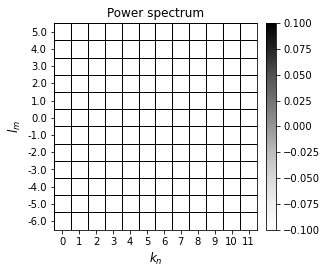

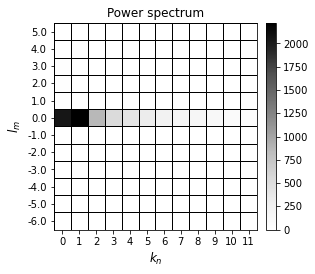

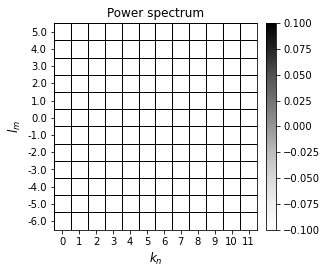

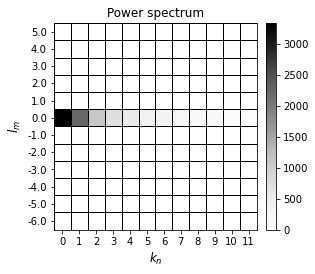

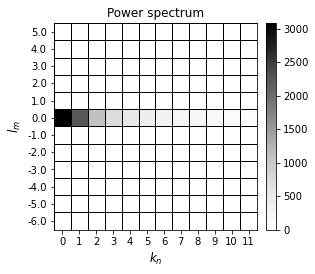

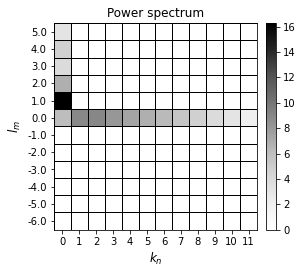

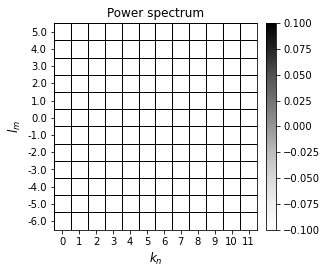

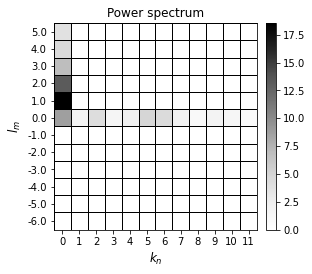

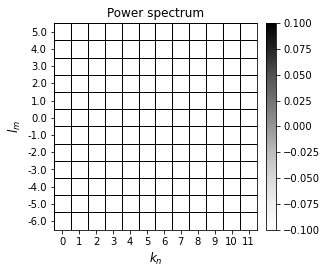

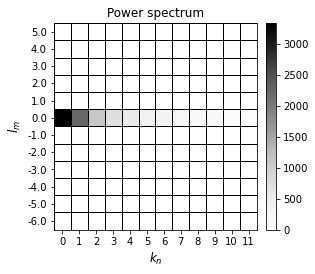

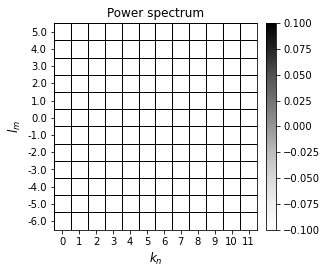

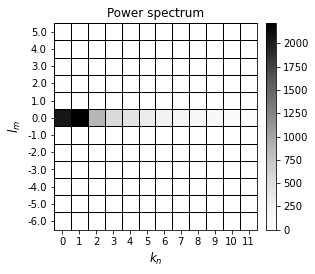

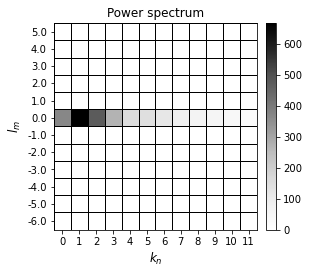

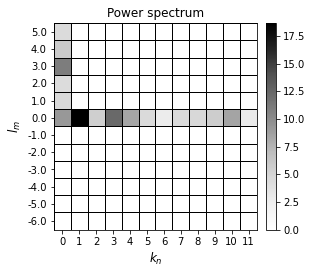

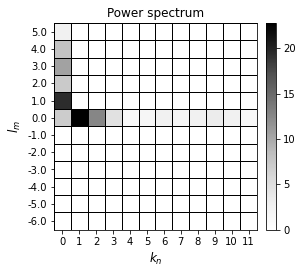

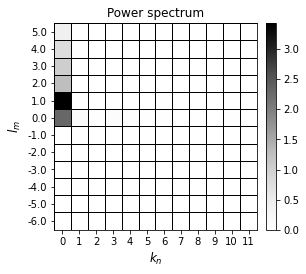

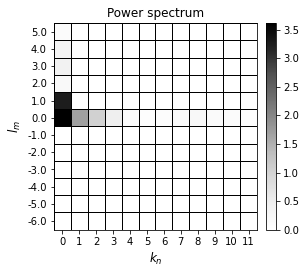

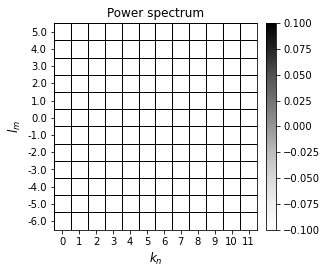

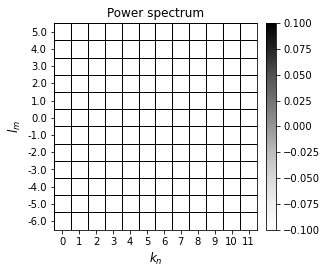

In [16]:
for i in range(30,55):

    idx = i
    
    fcoeffs = real[idx] + 1.0j * imag[idx]
    
    fs = (4,3.8)
    plt.figure(figsize=fs)

    im = plt.pcolormesh(np.abs(fcoeffs), edgecolors='k', cmap='Greys')
    plt.colorbar(im,fraction=0.05, pad=0.04)
    nhar_j = 12
    if nhar_j % 2 == 0:
        m_j = np.arange(-nhar_j/2,nhar_j/2)
    else:
        m_j = np.arange(-(nhar_j-1)/2,(nhar_j)/2)

    ylocs = np.arange(.5,12.5,1.0)
    plt.yticks(ylocs, m_j)
    plt.xticks(ylocs, np.arange(0,12))
    plt.title("Power spectrum")
    plt.xlabel(r'$k_n$', fontsize=12)
    plt.ylabel(r'$l_m$', fontsize=12)
    # plt.grid()
    # plt.savefig('axial_coeffs_rot.pdf', bbox_inches='tight')
    plt.show()
